In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = "retina"

In [30]:
theta_values = -2, -1, 0, 3, 7,

## HMM Orstein-Uhlenbeck process

$$
    x_{t+\Delta}^\ell = \kappa(\theta_{t, \ell} - x_{t, \ell}) \Delta + \sigma\sqrt{\Delta} W_t
$$

with $W_t \sim \cal{N}(0, 1)$

In [32]:
transition_matrix = jnp.array([
    [0.00,  0.05, 0.05, 0.05, 0.05],
    [0.10,  00.0, 0.10, 0.05, 0.05],
    [0.10,  0.20, 0.00, 0.05, 0.05],
    [0.10,  0.20, 0.01, 0.00, 0.05],
    [0.10,  0.20, 0.20, 0.20, 0.00],
])

p_stay = 1 - transition_matrix.sum(axis=1)
transition_matrix = transition_matrix.at[jnp.diag_indices(5)].set(p_stay)

transition_matrix

Array([[0.8       , 0.05      , 0.05      , 0.05      , 0.05      ],
       [0.1       , 0.7       , 0.1       , 0.05      , 0.05      ],
       [0.1       , 0.2       , 0.59999996, 0.05      , 0.05      ],
       [0.1       , 0.2       , 0.01      , 0.64      , 0.05      ],
       [0.1       , 0.2       , 0.2       , 0.2       , 0.3       ]],      dtype=float32)

In [122]:
url = """
https://query1.finance.yahoo.com/v7/finance/download/TSLA?period1=345427200&period2=1701993600&interval=1d&events=history&includeAdjustedClose=true
"""

In [144]:
date_init = datetime.timestamp(datetime(2000, 1, 1))
date_end = datetime.timestamp(datetime(2023, 12, 8))

config = {
    "events": "history",
    "period1": str(int(date_init)),
    "period2": str(int(date_end)),
    "includeAdjustedClose": "true"
}

In [173]:
assets = ["JPM", "AAPL", "SHEL", "WMT", "KO"]

In [180]:
from datetime import datetime

import requests
from io import StringIO

datasets = {}
for asset in assets:
    url = f"https://query1.finance.yahoo.com/v7/finance/download/{asset}"
    r = requests.get(
        url,
        headers={'User-agent': 'Mozilla/5.0'},
        params=config
    )

    data = pd.read_csv(StringIO(r.text))
    data["Date"] = pd.to_datetime(data["Date"])
    data = data.set_index("Date")

    series = data["Adj Close"]
    series.name = asset
    datasets[asset] = series
datasets = pd.DataFrame.from_dict(datasets)

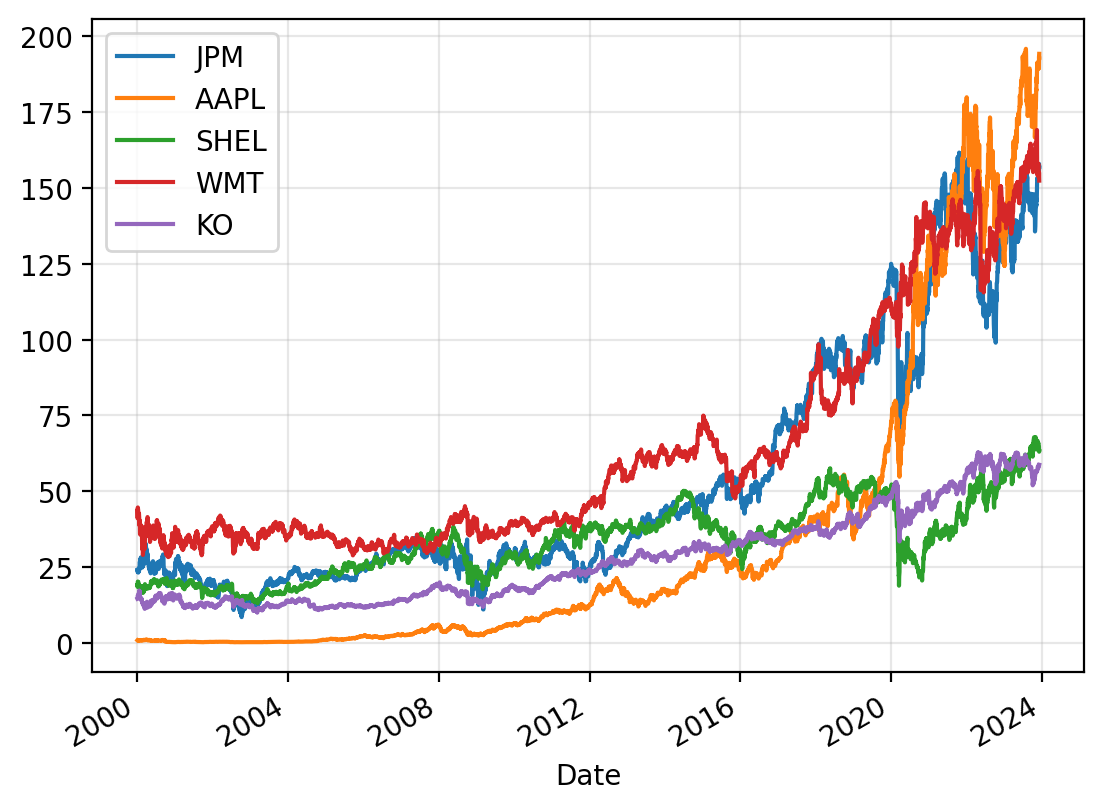

In [211]:
datasets.plot()
plt.grid(alpha=0.3)

In [293]:
returns = datasets.pct_change(5).dropna()
returns = jnp.array(returns.to_numpy())

$$
    \mathfrak{R}_T = P_T - P_T^*
$$

In [298]:
n_bandits = len(assets)
count_v = jnp.zeros(n_bandits)
value_v = jnp.zeros(n_bandits)

In [333]:
import chex

@chex.dataclass
class BanditState:
    count: jax.Array
    value: jax.Array
    key: jax.random.PRNGKey
    
    
@chex.dataclass
class BanditEWMState:
    value: jax.Array
    key: jax.random.PRNGKey

In [334]:
def epsilon_step(state, returns, epsilon):
    key_choice, key_arm = jax.random.split(state.key)
    is_greedy = jax.random.bernoulli(key_choice, p=1 - epsilon)
    random_choice = jax.random.choice(key_arm, n_bandits)
    
    action = state.value.argmax() * is_greedy + random_choice * (1 - is_greedy) 
    reward = returns[action]
    new_count = state.count[action] + 1
    new_value = state.value[action] + (reward - state.value[action]) / new_count
    
    state = state.replace(
        value=state.value.at[action].set(new_value),
        count=state.count.at[action].set(new_count),
        key=jax.random.split(state.key)[1]
    )
    
    return state, reward

In [335]:
def epsilon_ewm_step(state, returns, epsilon, alpha):
    key_choice, key_arm = jax.random.split(state.key)
    is_greedy = jax.random.bernoulli(key_choice, p=1 - epsilon)
    random_choice = jax.random.choice(key_arm, n_bandits)
    
    action = state.value.argmax() * is_greedy + random_choice * (1 - is_greedy) 
    reward = returns[action]

    new_value = state.value[action] + alpha * (reward - state.value[action])
    
    state = state.replace(
        value=state.value.at[action].set(new_value),
        key=jax.random.split(state.key)[1]
    )
    
    return state, reward

In [336]:
state = BanditState(count=count_v, value=value_v, key=jax.random.PRNGKey(314))

In [305]:
from functools import partial

In [318]:
state_final, returns_bandit = jax.lax.scan(partial(epsilon_step, epsilon=1e-6), state, returns)

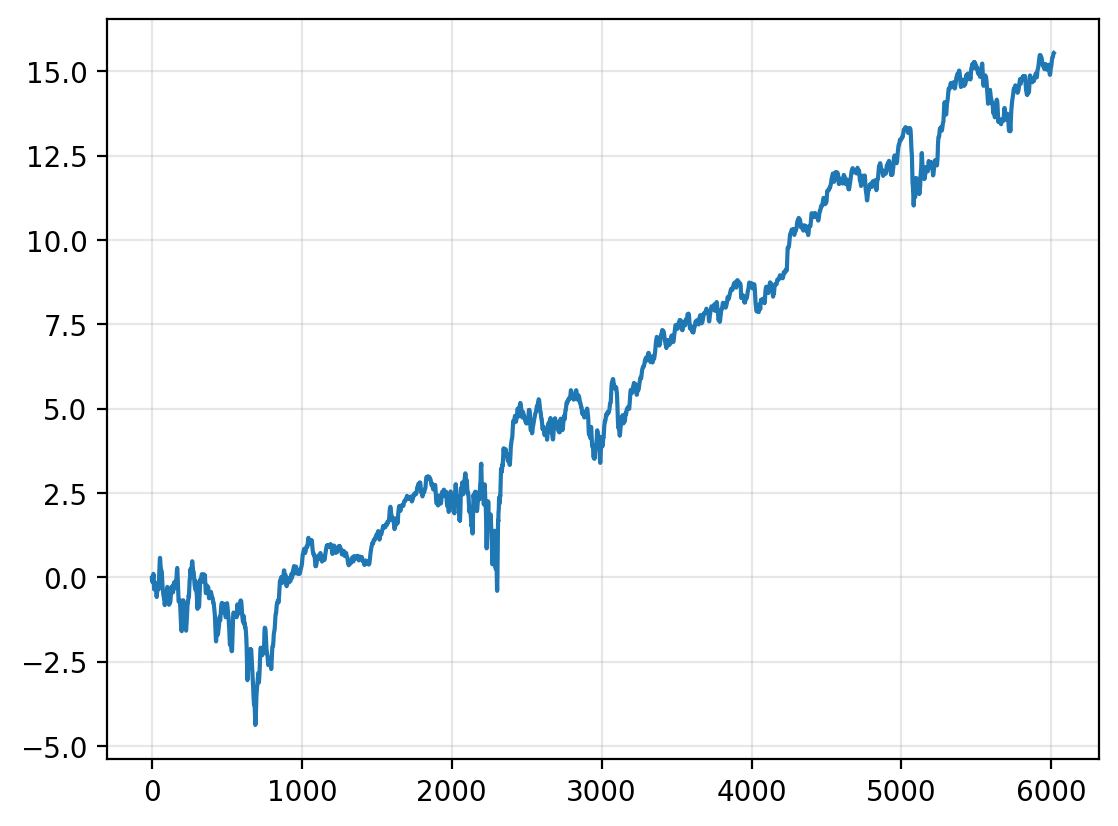

In [319]:
plt.plot(returns_bandit.cumsum())
plt.grid(alpha=0.3)

In [320]:
epsilon_values = jnp.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5])

In [325]:
@partial(jax.vmap, in_axes=(None, 0), out_axes=1)
def returns_bandit(state, epsilon):
    _, returns_bandit = jax.lax.scan(partial(epsilon_step, epsilon=epsilon), state, returns)
    return returns_bandit

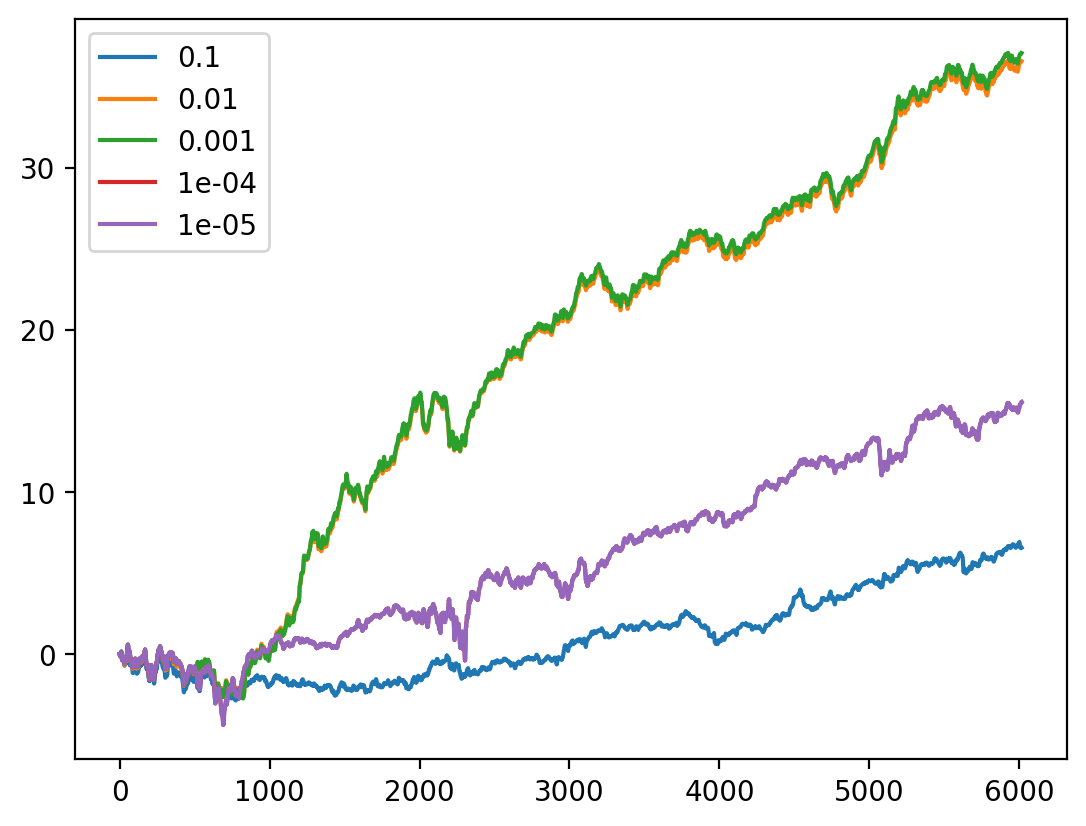

In [331]:
plt.plot(returns_bandit(state, epsilon_values).cumsum(axis=0), label=epsilon_values)
plt.legend()

## Non-stationary version

In [338]:
state = BanditEWMState(value=value_v, key=jax.random.PRNGKey(314))

In [343]:
state_final, returns_bandit = jax.lax.scan(partial(epsilon_ewm_step, epsilon=1e-6, alpha=0.9), state, returns)

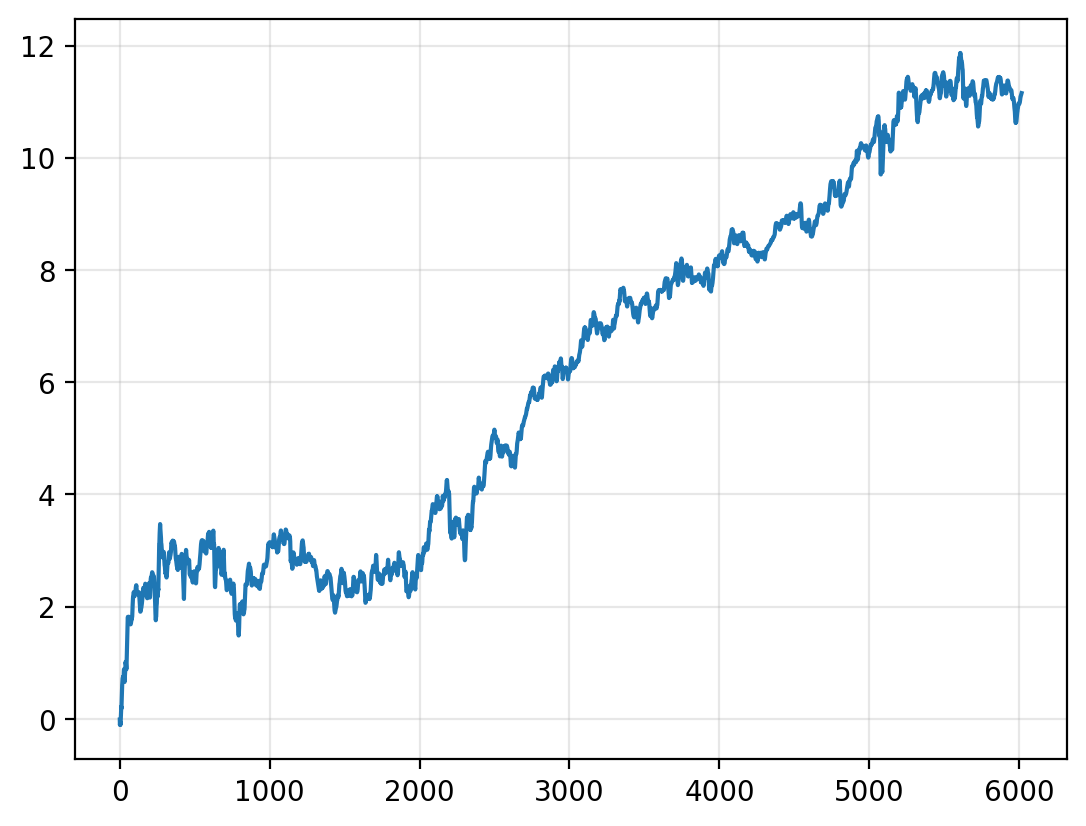

In [344]:
plt.plot(returns_bandit.cumsum())
plt.grid(alpha=0.3)

In [352]:
@partial(jax.vmap, in_axes=(None, 0, None))
@partial(jax.vmap, in_axes=(None, None, 0))
def returns_bandit(state, alpha, epsilon):
    _, returns_bandit = jax.lax.scan(partial(epsilon_ewm_step, epsilon=epsilon, alpha=alpha), state, returns)
    return returns_bandit.sum()

In [385]:
alpha_values = jnp.linspace(0.01, 1, 50)
epsilon_values = jnp.linspace(1e-7, 1, 50)
final_reward = returns_bandit(state, alpha_values, epsilon_values)

In [386]:
import seaborn as sns

In [388]:
import numpy as np

In [389]:
final_reward = pd.DataFrame(np.array(final_reward), index=alpha_values, columns=epsilon_values)

Text(50.72222222222221, 0.5, 'Alpha')

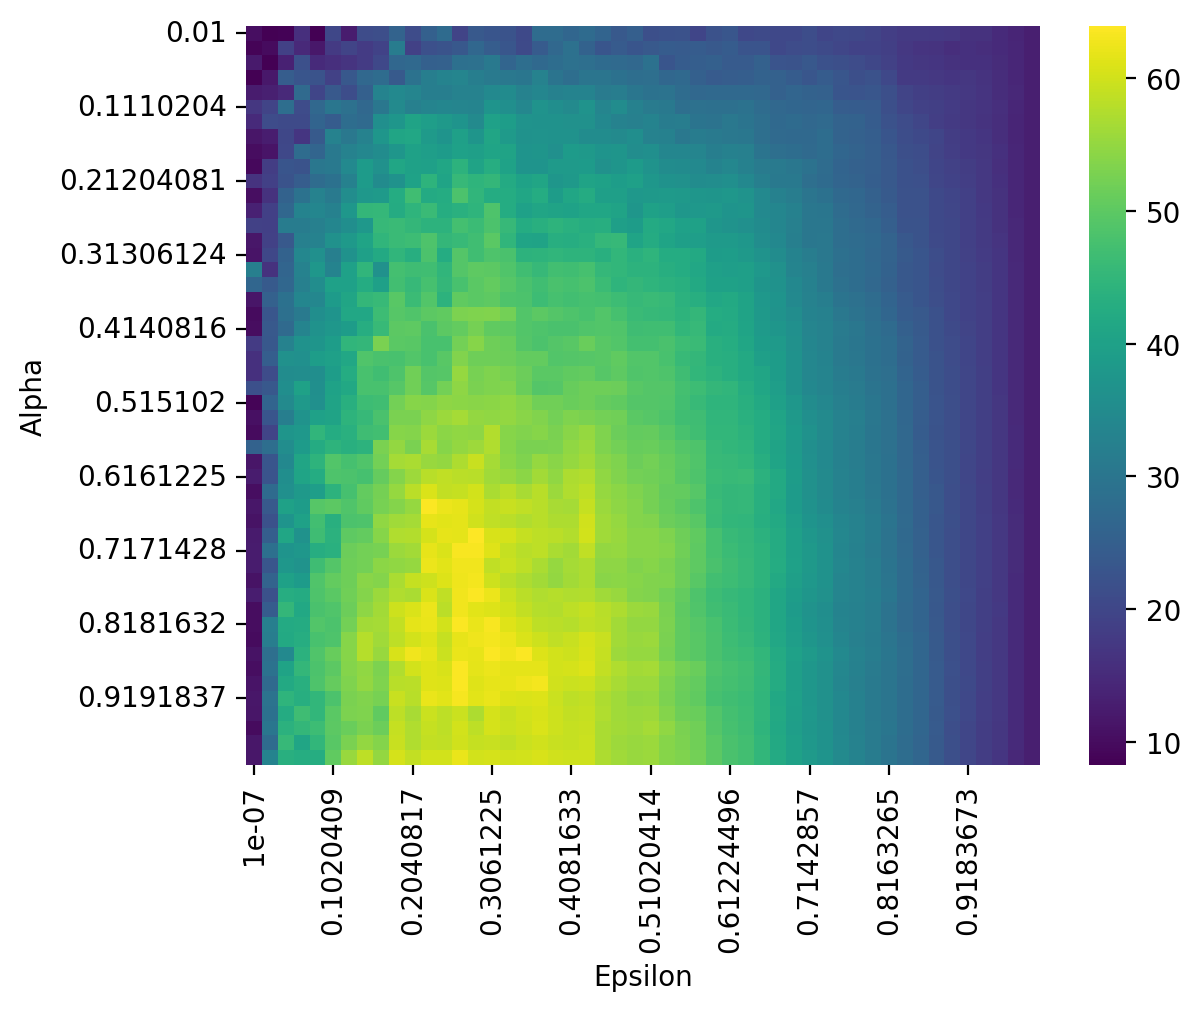

In [398]:
sns.heatmap(
    final_reward,
    # annot=True,
    xticklabels=5,
    yticklabels=5,
    cmap="viridis",
)
plt.xlabel("Epsilon")
plt.ylabel("Alpha")